In [1]:
# Indiana University Applied Machine Learning, Spring 2017
# Laura Kahn Programming Assignment 1
# March 21, 2017
# Code to compare the performance of Logistic Regression, Naive Bayes, Decision Tree and Nearest Neighbor on
#1996 adult income from Census data- want to predict whether a person makes more than $50,000 a year in income.

# Python 3.5.1 Code adapted from https://jasdumas.github.io/2016-05-04-RF-in-python/ 

#import libraries: dataframe manipulation, machine learning, os tools
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import csv
import matplotlib.pylab as plt
import scipy.stats as stats
import sklearn

#Import machine learning classifiers 
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

#Import ML metrics
from sklearn.cross_validation import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn import datasets

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Change working directory to be the same as where the data set is located
os.chdir("C:/Users/lkahn/Documents/526-AppliedMachineLearning")

In [3]:
#Load the data
data = pd.read_csv("adult.csv")
#Delete rows with no values or ? in the cell
data_clean = data.dropna()

In [4]:
#Get summary statistics for the first five rows
data_clean.head(n=5)

,Age,Workclass,FnlWgt,Education,Education1,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours per week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
#data types for each feature/variable
data_clean.dtypes 

Age                int64
Workclass         object
FnlWgt             int64
Education         object
Education1         int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-gain       int64
Capital-loss       int64
Hours per week     int64
Native-country    object
Income            object
dtype: object

In [6]:
#Get summary statistics including mean, standard deviation, quartiles
data_clean.describe()

,Age,FnlWgt,Education1,Capital-gain,Capital-loss,Hours per week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [7]:
#Summarize the data
import statsmodels.api as sm
data_clean.std()

Age                   13.640433
FnlWgt            105549.977697
Education1             2.572720
Capital-gain        7385.292085
Capital-loss         402.960219
Hours per week        12.347429
dtype: float64

In [8]:
#Data Exploration
#Note we are using prior knowledge that Education affects income in making this our target feature of the classifier
#Other features such as age, sex, etc could be used
data_clean.groupby('Education1').mean()

,Age,FnlWgt,Capital-gain,Capital-loss,Hours per week
Education1,,,,,
1,42.764706,235889.372549,898.392157,66.490196,36.647059
2,46.142857,239303.000000,125.875000,48.327381,38.255952
3,42.885886,232448.333333,176.021021,68.252252,38.897898
4,48.445820,188079.171827,233.939628,65.668731,39.366873
5,41.060311,202485.066148,342.089494,28.998054,38.044747
6,37.429796,196832.465166,404.574491,56.845659,37.052519
7,32.355745,194928.077447,215.097872,50.079149,33.925957
8,32.000000,199097.508083,284.087760,32.337182,35.780600
9,38.974479,189538.739739,576.800114,70.466622,40.575374


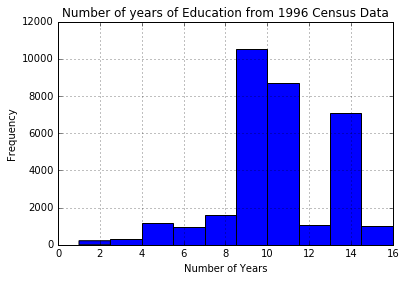

In [9]:
#Data Exploration using matplotlib
%matplotlib inline
#histogram of Education-num
data_clean.Education1.hist()
plt.title('Number of years of Education from 1996 Census Data')
plt.xlabel('Number of Years')
plt.ylabel('Frequency')

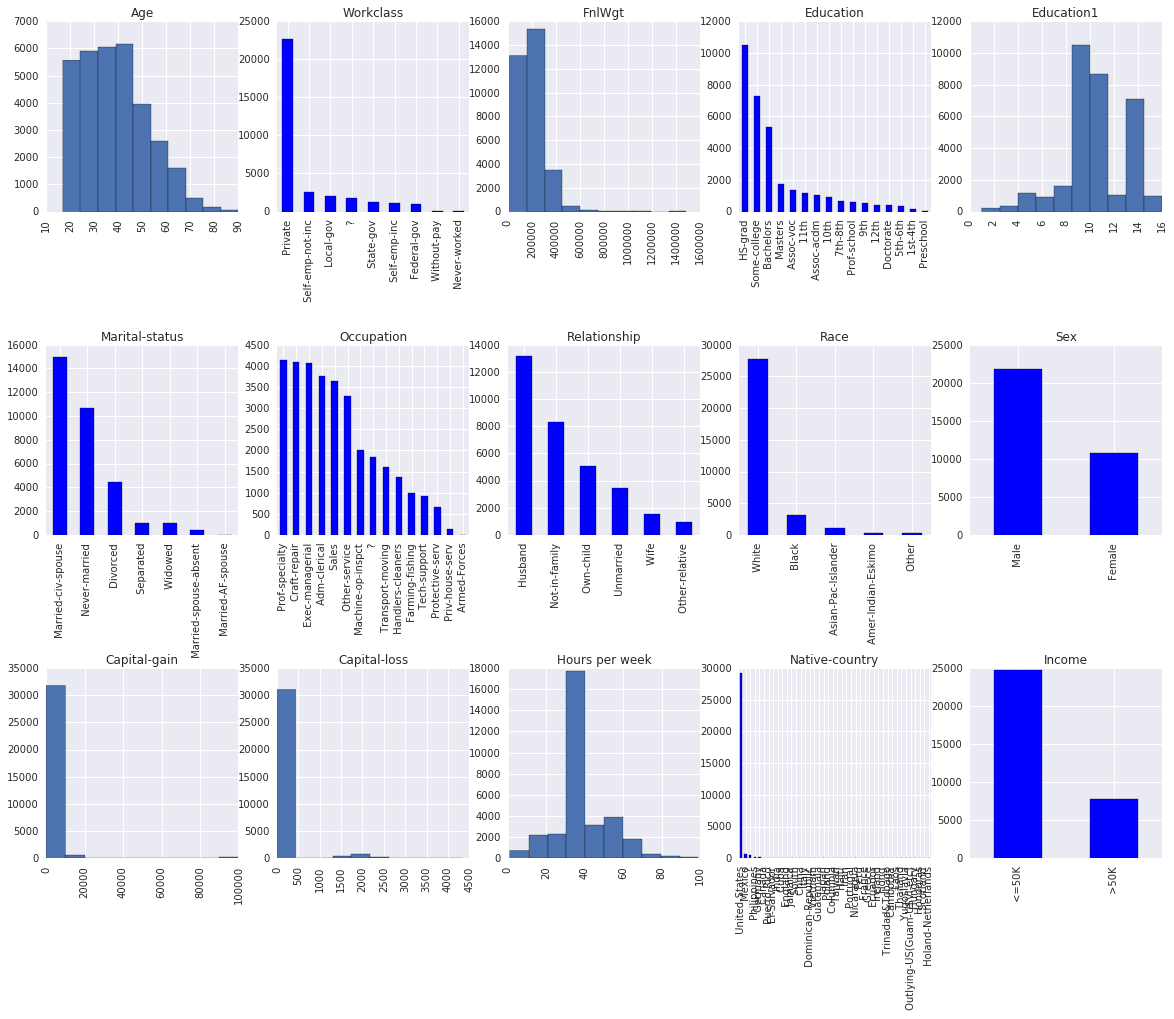

In [13]:
#Code adapted from https://www.valentinmihov.com/2015/04/17/adult-income-data-set/
#Plot distribution of each feature
fig = plt.figure(figsize=(20,15))
cols = 5
rows = (float(data_clean.shape[1]) / cols)
#Make a bar chart for each feature/column title
for i, column in enumerate(data_clean.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_clean.dtypes[column] == np.object:
        data_clean[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_clean[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

TypeError: unorderable types: str() < float()

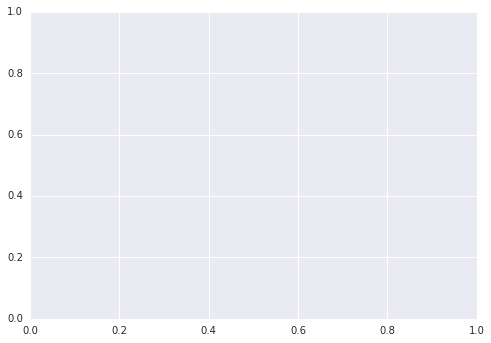

In [14]:
#To debug, let's print the line of code giving us the TypeError
data_clean[column].hist(axes=ax)

In [10]:
(data["Native-country"].value_counts() / data.shape[0]).head()

 United-States    0.895857
 Mexico           0.019748
 ?                0.017905
 Philippines      0.006081
 Germany          0.004207
Name: Native-country, dtype: float64

In [ ]:
#From this exploration, we see that 89.6% of the data comes from the US

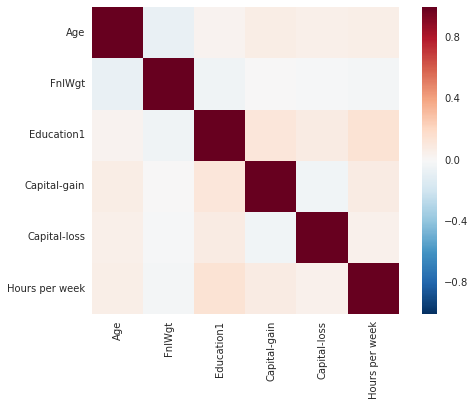

In [11]:
# Encode the categorical features as numbers
import seaborn as sns
from sklearn import preprocessing
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it as a heatmap
encoded_data, _ = number_encode_features(data_clean)
sns.heatmap(data.corr(), square=True)
plt.show()

In [13]:
#Now that the data has been explored, 
#let's split the data into a test and train set in order to build #a classifer.
encoded_data, encoders = number_encode_features(data_clean)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = (float(data_clean.shape[1]) / cols)

#Let's make a histogram for each feature in the columns of the 
#data_cleaned data set from above. 

for i, column in enumerate(data_clean.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    float(data_clean[column].hist(axes=ax))
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#Now let's do cross-validation to avoid overfitting
import sklearn.cross_validation as cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data_clean[encoded_data.columns - ["Income"]], 
        encoded_data["Income"], train_size=0.80)
scaler = preprocessing.StandardScaler()
X_train = pd.data_clean(scaler.fit_transform(X_train.astype("f64")), columns=X_train.columns)
X_test = scaler.transform(X_test.astype("f64"))

TypeError: float() argument must be a string or a number, not 'AxesSubplot'

In [14]:
#Logistic Regression ML Classifier
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
cls = linear_model.LogisticRegression()

encoders = {}
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders[column].classes_, yticklabels=encoders[column].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("F1 score: %f" % sklearn.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort()
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

NameError: name 'X_train' is not defined

In [4]:
#Now let's do a Multinomial Naive Bayes classifer model
#Transform the CSV file to a data frame
df = pd.read_csv("adult.csv", index_col=0, encoding='latin')
#See the first few rows of the data frame
df.head()

,Workclass,FnlWgt,Education,Education1,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours per week,Native-country,Income
Age,,,,,,,,,,,,,,
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [70]:
#Delete unnecessary columns (Education, Workclass, FnlWgt, Marital-status, Relationship, Capital-gain, Capital-loss, 
#Native-country columns) from the table using pandas
keep_col = ['Education1', 'Occupation', 'Race', 'Sex', 'Hours per week', 'Income']

df[keep_col].head()

,Education1,Occupation,Race,Sex,Hours per week,Income
Age,,,,,,
39,13,Adm-clerical,White,Male,40,<=50K
50,13,Exec-managerial,White,Male,13,<=50K
38,9,Handlers-cleaners,White,Male,40,<=50K
53,7,Handlers-cleaners,Black,Male,40,<=50K
28,13,Prof-specialty,Black,Female,40,<=50K


In [6]:
#Next, let's do a Multinomial Naive Bayes classifier
#We need to represent X and Y as count vectors
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df['Education'])
X.shape

(32561, 23)

In [8]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

y = df['Income']

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(mnb, X, y, scoring="accuracy", cv=10)
print("Average accuracy, 10-fold cross validation:")
print(np.mean(scores))

Average accuracy, 10-fold cross validation:
0.779583173343


In [ ]:
#How does this average accuracy compare to the null error?